## CS4035 - Cyber Data Analytics - Lab 2 (Anomaly Detection) 

### Group Number : 33
### Student 1 
#### Name : Shipra Sharma
#### ID : 5093406
### Student 2
#### Name : Sudharshan Swaminathan
#### ID : 5148340

### Readme (setup instructions)

We have attached the `requirements.txt` file. The required libraries, apart from the ones that are already not being used by sklearn, can be installed from there. In case of any problems, they can be installed manually too: `tslearn`, `h5py` and `statsmodels`. 

##### Import statements

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import normalize
import statsmodels
from statsmodels.tsa.arima_model import AR
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import quantile_transform
import re
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statistics
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from nltk import ngrams

### 1. Familiarization task

In [23]:
#Loading the data
training_data = pd.read_csv("BATADAL_dataset03.csv")
training_evaluation_data = pd.read_csv("BATADAL_dataset04.csv")
training_eval_data = training_evaluation_data
training_data.head(3)

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0


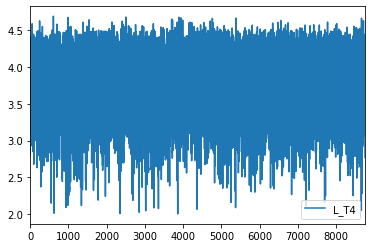

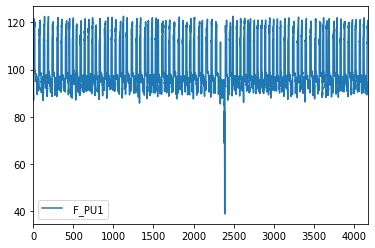

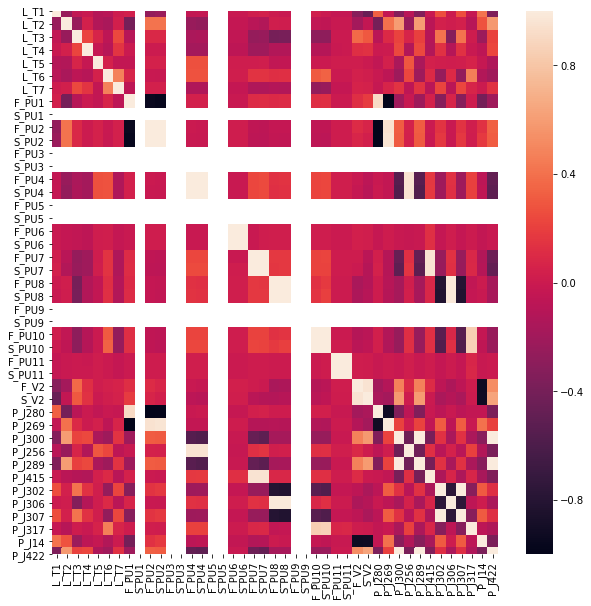

In [24]:
#dropping the datetime and the label (ATT_FLag)
clean_training_data = training_data.copy()
clean_training_data = clean_training_data.drop(columns=['ATT_FLAG', 'DATETIME'])

#plot a signal from training data
clean_training_data.plot( y ='L_T4')

#plot a signal from evaluation data
training_evaluation_data.plot ( y = ' F_PU1')

#plotting a correlation matrix
corr = clean_training_data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

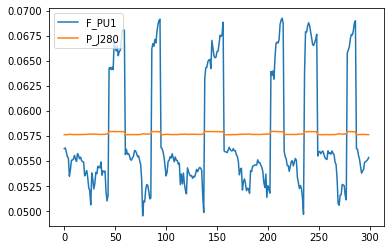

In [25]:
signals = list(clean_training_data.corr())
#uncomment to find the index of the desired signals
#print(signals) 

#assigning the index values as per the signal list
fpu1_signal = 7
pj280_signal = 31

#plotting these signals in normalised form to see a correlation betweent the two
plt.plot(normalize(clean_training_data[signals[fpu1_signal]][:300].values.reshape(1, -1)).reshape(-1, 1), label=signals[fpu1_signal])
plt.plot(normalize(clean_training_data[signals[pj280_signal]][:300].values.reshape(1, -1)).reshape(-1, 1), label=signals[pj280_signal])   
plt.legend()
plt.show()

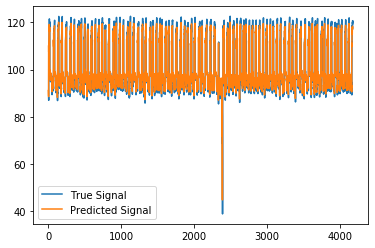

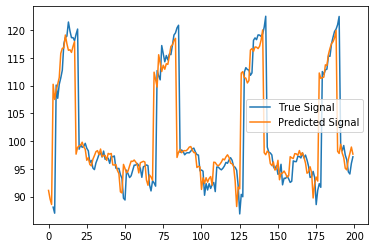

In [26]:
training_evaluation_data.columns = training_evaluation_data .columns.str.replace(' ', '')
signal = "F_PU1"

# define and fit the AR model 
z = 3 #considering 3 at a time
predictor = AR(clean_training_data[signal])
predictor_fit = predictor.fit(z)

# function for predicting next value in serie
def next_value_prediction(prediction_coefficient, past_data):
    result = prediction_coefficient[0]
    for i in range(1, len(prediction_coefficient)):
        result += prediction_coefficient[i] * past_data[-i]
    return result

# define the test signal
test_signal = training_evaluation_data[signal]
# obtain AR coefficients
ar_coefficient = predictor_fit.params
# keep the first p test signal values  
past_data = [training_evaluation_data[signal].iloc[x] for x in range(0,z)]

# Predictions are made in this section
predictions_made = list()
for t in range(z,len(test_signal)):
    new_prediction = next_value_prediction(ar_coefficient, past_data)
    predictions_made.append(new_prediction)
    old_prediction = test_signal[t]
    past_data.append(old_prediction)

# # plot all predicted values
plt.plot(training_evaluation_data[signal].iloc[z:])
plt.plot(predictions_made)
plt.legend(['True Signal','Predicted Signal'])
plt.show()

# plot first 200 values to make predcition a bit clear 
plt.plot(training_evaluation_data[signal][:200].iloc[z:])
plt.plot(predictions_made[:200])
plt.legend(['True Signal','Predicted Signal'])
plt.show()


##### Types of Signals: 
We have two training datasets, each of which has multiple types of sensor signals (43) present. These signals depict multiple properties like level in tank (L_T4, L_T5), pressure (P_J280, P_J300) and flow levels of pumps (F_PU1) and valves(F_V2). There are also values which depicts whether a sensor is active or not. The plots of signals L_T4 (training data) and F_PU1 (evaluation data) shows that each signal is accompanied by two values i.e. its labels and timestamps.
##### Cyclic behaviour:
The heat map depcits clearly that lighter the color, the more correlated attributes are. We can observe that L_T6 highly correlated which gives a corelation among water level in tanks. Another example is a highly correlated pair i.e. F_PU1 and P_J280 which shows that flow level and pressure are correlated. We can observe the cyclic behaviour between this pair through one of our output plots.
##### Prediction
We consider AutoRegression model to do the signal prediction. Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. We use it as it is a very simple model that can result in accurate forecasts on a range of time series problems. For this particular task, we use F_PU1
signal where the prediction seems to be matching the original signal which shows that prediction easy to spot. The prediction is done using the evaluation training set.

### 2. LOF - Sudharshan Swaminathan

As can be seen from the plotted LOF scores, all the anomalies are visible in the negative y axis (scores less than -1). More negative the score, more anomolous the data point. LOF scores are being calculated in the following way:

1. Extract the test labels from the training set 2. Change the value of the test labels from (-999, 1) to (1, -1) so that it can be matched with the results from LOF.
2. Fit the training data set 1 using the LOF function. 
3. Use the computed factors to calculate the possible outliers using the predict function. Here, the novelty methods have been used.
4. Compare the results on the training evaluation set (training set 2) with the test labels from step 1 to compute False Positives and True Positives.

In [20]:
# pre-processing
#extracting the labels for testing the performance later
test_labels = training_evaluation_data['ATT_FLAG'].values

# when attack => ATT_FLAG = 1 ; outlier = -1 (ATT_FLAG = 1) ; inlier = 1 (ATT_FLAG = -999)
attack_indices = []
for i in range(len(test_labels)):
    if test_labels[i] == -999:
        test_labels[i] = 1
    elif test_labels[i] == 1:
        test_labels[i] = -1
        attack_indices.append(i)

# dropping the string column and (as sequence analysis not required) and att_flag value (as not required to be given to the test algorithm)
training_evaluation_data = training_evaluation_data.drop(['DATETIME','ATT_FLAG'], axis='columns')

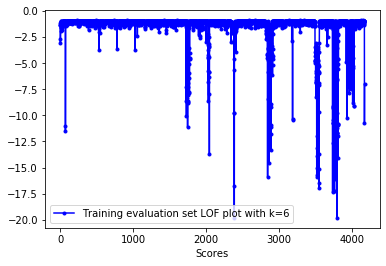

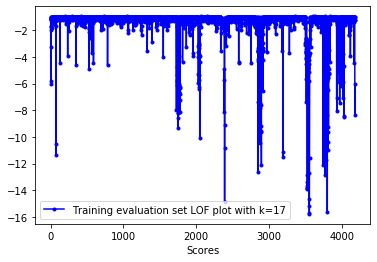

6 - fp: 421, tp: 170 fn: 49
6 - fpr: 0.408, tpr: 0.631 auc: 0.835, precision: 0.288


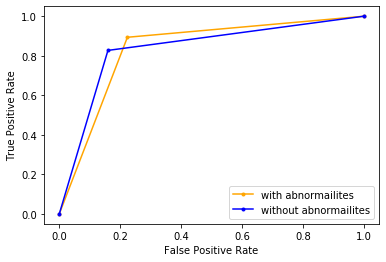

17 - fp: 408, tp: 164 fn: 55
17 - fpr: 0.417, tpr: 0.632 auc: 0.823, precision: 0.287


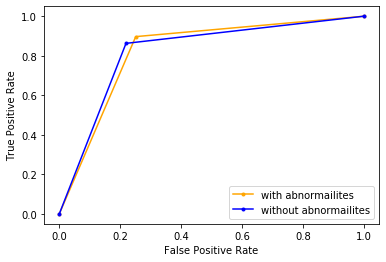

In [21]:
def plot_lof_scores(df_train,df_test,knn):
    lof = LocalOutlierFactor(n_neighbors=knn, novelty=True, contamination = 0.052)
    lof.fit(df_train)
    is_inliers = lof.predict(df_test) # Inliers are labeled 1, while outliers are labeled -1
    scores = lof.score_samples(df_test)
    #     plotting LOF scores
    plt.plot(scores, marker='.',color="blue", label="Training evaluation set LOF plot with k="+str(knn))
    plt.xlabel('Scores')
    plt.legend()
    plt.show()
    
# Plotting LOF scores with k = 6
plot_lof_scores(clean_training_data, training_evaluation_data,6)
# Plotting LOF scores with k = 17
plot_lof_scores(clean_training_data, training_evaluation_data,17)

def remove_abnormalities(df_train, knn):
    lof_clean = LocalOutlierFactor(n_neighbors=knn,contamination = 0.052)
    lof_clean_abnormalities = lof_clean.fit_predict(df_train)
    lof_clean_scores = lof_clean.negative_outlier_factor_
    abnormalities = []
    
    for rank in range(len(lof_clean_abnormalities)):
        if lof_clean_abnormalities[rank] == -1:
#             print(lof_clean_scores[rank])
            abnormalities.append(rank)
    for ab in abnormalities:
        df_train = df_train.drop(index = ab)
    
    return df_train
    
df_train_clean = remove_abnormalities(clean_training_data, 6)
    
def lof_novelty(df_train, df_test, attack_indices, knn):
    lof = LocalOutlierFactor(n_neighbors=knn, novelty=True, contamination = 0.052)
    lof.fit(df_train)
    is_inliers = lof.predict(df_test) # Inliers are labeled 1, while outliers are labeled -1
    scores = lof.score_samples(df_test)
    attack_indices_test = []
    for i in range(len(is_inliers)):
        if is_inliers[i] == -1:
            attack_indices_test.append(i)
    false_positives = list(set(attack_indices_test) - set(attack_indices))
    true_positives = [item for item in attack_indices_test if item in attack_indices]
    false_negatives = list(set(attack_indices) - set(attack_indices_test))
    return false_positives, true_positives, false_negatives, is_inliers


auc_scores=np.zeros(50)

# experimenting with different k values
# for kn in range(2,10):
#     fp, tp, fn, result_labels = lof_novelty(df_train, df_test, attack_indices, kn)
#     print("%d - fp: %d, tp: %d fn: %d" % (kn, len(fp), len(tp), len(fn)))
#     fpr, tpr, _ = roc_curve(test_labels, result_labels)
#     auc = roc_auc_score(test_labels, result_labels)
#     print("%d - fpr: %.3f, tpr: %.3f auc: %.3f" % (kn, statistics.mean(fpr), statistics.mean(tpr), auc))
#     auc_scores[kn-2] = auc


# print("max auc score for kn = ", np.argmax(auc_scores)+2)
def plot_roc(df_train, df_train_clean, df_test, attack_indices, kn):
    
    fp, tp, fn, result_labels = lof_novelty(df_train, df_test, attack_indices, kn)
    print("%d - fp: %d, tp: %d fn: %d" % (kn, len(fp), len(tp), len(fn)))
    fpr, tpr, _ = roc_curve(test_labels, result_labels)
    auc = roc_auc_score(test_labels, result_labels)
    precision = len(tp) / (len(tp)+len(fp))
    print("%d - fpr: %.3f, tpr: %.3f auc: %.3f, precision: %.3f" % (kn, statistics.mean(fpr), statistics.mean(tpr), auc, precision))
    
    fp_clean, tp_clean, fn_clean, result_labels_clean = lof_novelty(df_train_clean, df_test, attack_indices, kn)
    fpr_clean, tpr_clean, _ = roc_curve(test_labels, result_labels_clean)
    auc = roc_auc_score(test_labels, result_labels_clean)
    
    plt.plot(fpr, tpr, marker='.',color="orange", label="with abnormailites")
    plt.plot(fpr_clean, tpr_clean, marker='.',color="blue", label="without abnormailites")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()   
    


kn = 6 
plot_roc(clean_training_data, df_train_clean, training_evaluation_data, attack_indices, kn)
kn = 17
plot_roc(clean_training_data, df_train_clean, training_evaluation_data, attack_indices, kn)

On trying various k neighbours from a range of 2 to 50, it was realised that k with values 6 and 17 gave the best results (the trials have been commented in the code, and only these 2 values have been taken for clarity in the report). These 2 values were the chosen according to the maximum AUC under the ROC curve. Also, these 2 values gave a balance between false positives and true positives, therefore the most suitable. 

The abnormalities that are seen in the training samples are not very far away from the cluster as the scores given by *negative_outlier_factor_* are not very far away from -1 to be a probable attack, but far enough to be an outlier and therefore an abnormality. So these might just be malfunctioning of signals, thereby considered as an outlier and can be removed from the training set.

The anomalies that are detected using LOF are based on outliers, more negative the LOF score (using *negative_outlier_factor_*), more further away is the datapoint, more probable it is to be an outlier and therefore, an anomaly.

### 3. PCA - Shipra Sharma

The task is performed as following:
1. Normalize the datasets as PCA takes normalised data
2. Find the importance of each component of the data set by finding the explaied variance ratio
3. Pick the number of important components and find projections
4. Find projections for the chosen number of important components on both the data sets
5. Calculate residuals of each point in the signal and combine the same

In [27]:
#recording the timestamps of the attacks in a list
timestamps_attack = list(training_eval_data.loc[training_eval_data['ATT_FLAG']==1].index)
print(len(timestamps_attack))

#dropping the datetime and 'ATT_FLAG' from evaluation training set as well
clean_evaluation_data = training_eval_data.copy()
clean_evaluation_data = clean_evaluation_data.drop(columns=['ATT_FLAG', 'DATETIME'])

219


In [28]:
def pca_residuals(train_data1,train_data2):
    
    # step 1
    normalizer = Normalizer()
    normalized_train_data1 =pd.DataFrame(normalizer.fit_transform(train_data1))
    normalized_train_data2 = pd.DataFrame(normalizer.fit_transform(train_data2))

    # step 2
    pca = PCA()
    pca.fit(normalized_train_data1)
    print(pca.explained_variance_ratio_)
    
    # step 3
    pca_n = PCA(n_components = 15)
    pca_n.fit(normalized_train_data1)
    train_data_projection = pca_n.transform(normalized_train_data1)
    eval_data_projection = pca_n.transform(normalized_train_data2)
    
    # step 4 - matrix multiplication of projection and components
    components = pca_n.components_
    train_data_multiply = np.matmul(train_data_projection,components)
    eval_data_multiply =  np.matmul(eval_data_projection,components)
    
    # step 5 - calculating residuals by substracting the matrix multiplication from normalized value
    train_data_residuals = np.subtract(np.array(normalized_train_data1),train_data_multiply)
    eval_data_residuals = np.subtract(np.array(normalized_train_data2),eval_data_multiply)
    
    # combine point wise residuals
    train_data_residuals = np.sum(np.square(train_data_residuals),axis=1)
    eval_data_residuals = np.sum(np.square(eval_data_residuals),axis=1)
    
    return train_data_residuals, eval_data_residuals

[4.28863462e-01 2.87477511e-01 9.63679745e-02 7.96212084e-02
 6.50087149e-02 3.54596191e-02 2.69541784e-03 1.23769430e-03
 1.11080294e-03 7.53193281e-04 4.68901833e-04 2.21064511e-04
 1.68447095e-04 1.49070256e-04 1.01652721e-04 8.06353915e-05
 5.01064951e-05 3.74327705e-05 3.61903514e-05 3.36276395e-05
 2.97222321e-05 2.14115469e-05 3.09021143e-06 2.66227377e-06
 1.70766358e-07 1.05264995e-07 4.63193274e-08 2.60536800e-08
 1.36960710e-08 1.23302614e-08 1.15851628e-08 3.97080641e-10
 7.44504154e-11 8.02464438e-12 1.34848883e-12 1.05819241e-12
 3.01733015e-16 2.66697555e-33 2.66697555e-33 2.66697555e-33
 2.66697555e-33 2.66697555e-33 2.66697555e-33]


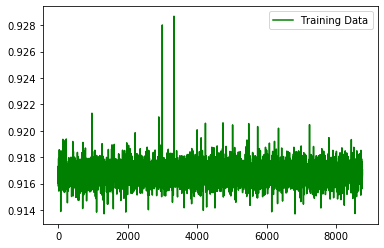

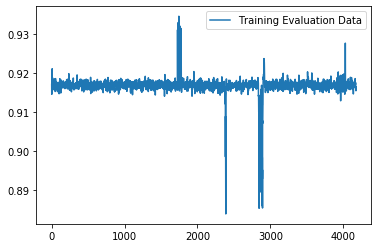

In [30]:
train_data_residuals, eval_data_residuals = pca_residuals(clean_training_data,clean_evaluation_data)

# plot the residuals for both datasets
plt.plot(train_data_residuals,'g')
plt.legend(['Training Data'])
plt.show()

plt.plot(eval_data_residuals)
plt.legend(['Training Evaluation Data'])
plt.show()

In [32]:
#Pca Evaluation

# set the thresholds for spotting anomalies
max_thresh = np.max(train_data_residuals)
min_thresh = np.min(train_data_residuals)

potential_attacks= np.where((eval_data_residuals>max_thresh))
print(potential_attacks)

potential_attacked_entries = potential_attacks[0]
unique_attack_entries = set(potential_attacked_entries)
        
potential_attacks= np.where((eval_data_residuals>max_thresh))
potential_attacked_entries = potential_attacks[0]
for time_point in potential_attacked_entries:
    unique_attack_entries.add(time_point)
unique_attack_entries = list(unique_attack_entries)
unique_attack_entries.sort()

# TP and FP
TruePositives = 0
FalsePostives = 0
for j in unique_attack_entries:
    if j in timestamps_attack:
        TruePositives +=1
    else:
        FalsePostives +=1                
    
print("PCA True Positives are: " + str(TruePositives))
print("PCA False Postives are: " + str(FalsePostives))

(array([1727, 1732, 1736, 1741, 1742, 1743, 1744, 1745, 1746, 1748, 1749,
       1750, 1751, 1754, 1755, 1758, 1759, 1760, 1764, 1765, 1766, 1767,
       1773, 1774, 1776], dtype=int64),)
PCA True Positives are: 21
PCA False Postives are: 4


Principal component analysis, or PCA, is a statistical procedure that allows one to summarize the information content in large dataset (like ours with 43 signals) by means of a smaller set of important principal components that can be more easily visualized and analyzed. For the given task we were supposed to find the PCA residual for each point in the signal. We did so for both the training data. To find the best number of components, we varied the value of n from 6-15 depending on the explained variance ratio and found that the best result comes for the value as n= 15. In the above plots it can be seen that the evaluation training dataset has more spikes than the training dataset. These high spikes refer to abnormalities as the value is largely deviating from the average value of the signals, this can be seen clearly in both the training sets. Since, PCA works on variance hence, it can be used to find anomalies where in any given set, there is observable changes in variance. To analyse the detection of attacks via PCA we set the threshold with the maximum and minimum residuals of the first training data and calculate anomalies on evaluation training data. The results of PCA would be explained in the comparison task.

### 4. ARMA - Shipra Sharma

Following steps are performed while implementing ARMA:
1. Analyse whether the given signal is staionary and plot autocorrelation and partial correlation for L_T1 signal
2. Using AIC to find best order of p and q
3. Find the training and evaluation residuals and plot them respectively
4. Find the anomalous region based on threshold and residual values
5. Spot potential_attacks and evaluate ARMA by finding the TP and FP for the chosen signal data

p-value: 0.000000


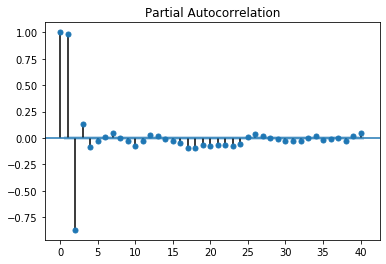

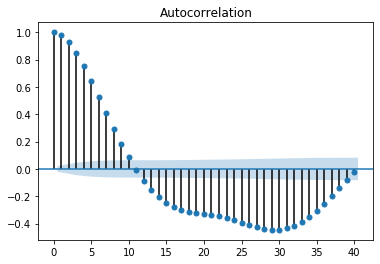

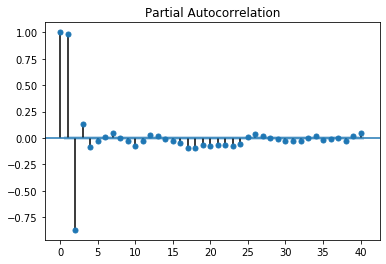

In [33]:
#converting the signal into series to derive the ARMA autocorrelation and partial-autocorrelation plots
signal = "L_T1"
signal_arma = training_data[signal]
series = pd.Series(signal_arma)

#running the adfuller test to check whether the series is stationary or not

stationary_or_not = adfuller(series)

print('p-value: %f' % stationary_or_not[1])
#since p value is less than 0.5, hence the given series is stationary

if(stationary_or_not[1]<0.05):
    d=0
else:
    d=1
    
#plotting acf and pacf to get an idea about the order of p and q
plot_acf(series)
plot_pacf(series)

In [34]:
# As required, implementing AIC to find the best values of p, d and q
best_aic = np.inf 
best_order = None
best_model = None

p_range = range(1,4) 
q_range = range(1,3) 
d_range =range(0,1)
for i in p_range:
    for j in q_range:                  
                temp_model = smt.ARIMA(training_data[signal], order=(i,d,j)).fit(method='mle', trend='nc')
                temp_aic = temp_model.aic
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_order = (i, d, j)
                    best_model = temp_model
            

print('Best Order: {}'.format(best_order))

D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best Order: (3, 0, 2)


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


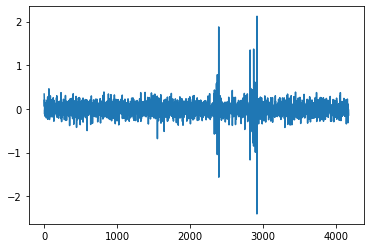

In [35]:
signal_eval = ' '+signal

#applying ARMA model to evaluation training data
evaluation_arma_model =smt.ARIMA(training_evaluation_data["L_T1"], order = best_order).fit(method='mle', trend='nc')

#calculating evaluation data residual
eval_residual = evaluation_arma_model.resid[2:]
plt.plot(eval_residual)

(-2.4049522467398923, 2.1221523042609847)

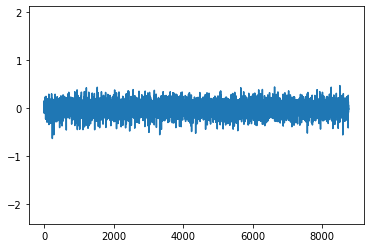

In [36]:
#Applying ARMA to training model and calculating training data residual
train_residual = best_model.resid[2:]
plt.plot(train_residual)

#to spot the difference between actual and predicted
plt.ylim(ymin=min(eval_residual),ymax=max(eval_residual))

In [37]:
evaluation_standard = np.std(eval_residual)
print (evaluation_standard)
startThreshold = 2 * evaluation_standard
maxThreshold = 4 * evaluation_standard
threshold = startThreshold
while len(train_residual[train_residual > threshold])>0 and threshold < maxThreshold:
    threshold = threshold * 1.001
print(threshold)

0.1477380352129328
0.47264898536267524


In [38]:
#ARMA Evaluation

potential_attacks_arma= np.where(eval_residual > threshold)
print(potential_attacks_arma)

potential_arma_attacked_entries = potential_attacks_arma[0]
unique_attack_entries_arma = set(potential_arma_attacked_entries)
        
for time_point in potential_arma_attacked_entries:
    unique_attack_entries_arma.add(time_point)
unique_attack_entries_arma = list(unique_attack_entries_arma)
unique_attack_entries_arma.sort()

# TP and FP
TruePositives = 0
FalsePostives = 0
for j in unique_attack_entries_arma:
    if j in timestamps_attack:
        TruePositives +=1
    else:
        FalsePostives +=1                
    
print("ARMA True Positives for the L_T1 signal are: " + str(TruePositives))
print("ARMA False Postives for the L_T1 signal are: " + str(FalsePostives))

(array([2363, 2375, 2394, 2825, 2873, 2892, 2895, 2919], dtype=int64),)
ARMA True Positives for the L_T1 signal are: 4
ARMA False Postives for the L_T1 signal are: 4


ARMA (Autoregressive moving average model) uses the p (previous values) and q (residual values) of a given signal/series (here we use L_T1) to understanding the past and predicting the future values. While performing procedures on a signal, the first step might always be to check whether its stationary or not. In our case it turned out to be a stationary one. Next was to find the range of p and q from the autocorrelation plots. From the ACF plot, we can deduce that a positive correlation exists between 0-10 hence the MA order could be between 1 and 2. The PACF plot gives the exact relation for the AR constants. We then use AIC to compute the best parameters for the ARMA model (Here we tried with different range of p and q and used the best one). These parameters are then used to get the residuals for both the training set and evaluation set. We aim to find the anomalous region by tuning the threshold accordingly. We tried different multipliers for evaluating the maximum and standard threshold to limit the anomalous region for the training data. We can clearly spot the difference between the residuals of the training and evaluation data by looking at the two plots above. The sudden spikes in the first residual plot symbolises the abnormalities and such instance must be treated in order to suspect attacks. The results are mentioned in the comparison task.

In our analysis, ARMA works better for detecting anomalies that arise in a sudden timestamp and not frequent/repeating manner, because it uses previous values and residuals to predict the next values. This is because, if there are too much anomalies in the previous data and a high spike might be missed. 

### 5. N-gram - Sudharshan Swaminathan

Visualise discretization - The dicretized data has been plotted below. As can be seen the signal is shown by blue, which has then been coverted to particular discrete data using SAX transform shown in green. Here, only 2 discrete values have been used which depends on the number of PAA segments and the alphabet mapping size used. 

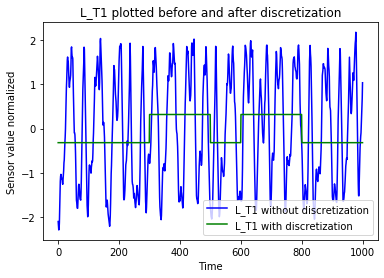

In [39]:
def plot_discrete(df_train, column):
    df_train_1 = df_train[column][:1000] #taking the first 1000 rows for clarity
    scalar = TimeSeriesScalerMeanVariance(mu=0., std=np.std(df_train_1)).fit_transform(df_train_1) # Rescale time series

    sax = SymbolicAggregateApproximation(n_segments=10, alphabet_size_avg=4)
    sax_d = sax.fit_transform(scalar)
    df_discrete = sax.inverse_transform(sax_d)[0]

    seq_data = df_train_1.values - df_train_1.values.mean()
    plt.title(column + " plotted before and after discretization")
    plt.plot(seq_data, color='b', label='L_T1 without discretization')
    plt.plot(df_discrete, color='green', label='L_T1 with discretization')
    plt.xlabel('Time')
    plt.ylabel('Sensor value normalized')
    plt.legend()
    plt.show()
    
plot_discrete(clean_training_data, 'L_T1')

,aaaa,aaab,aabb,abbb,bbbb,bbba,bbaa,baaa,bbbc
0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,849.0,1.0,1.0,1.0,148.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN


,aaaa,aaab,aabb,abbb,bbbb,bbba,bbaa,baaa,bbbc,bbcc,bccc,cccc
0,414.0,1.0,1.0,1.0,583.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,232.0,NaN,NaN,NaN,765.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2,699.0,1.0,1.0,1.0,298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,414.0,1.0,1.0,1.0,580.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,567.0,NaN,NaN,NaN,1.0,1.0,1.0,4.0


for column: L_T1 => fp: 1658 , tp: 60, precision: 0.03492
for column: L_T2 => fp: 13 , tp: 3, precision: 0.18750
for column: L_T3 => fp: 655 , tp: 60, precision: 0.08392
for column: L_T4 => fp: 510 , tp: 73, precision: 0.12521
for column: L_T5 => fp: 596 , tp: 0, precision: 0.00000
for column: L_T6 => fp: 373 , tp: 60, precision: 0.13857
for column: L_T7 => fp: 1567 , tp: 67, precision: 0.04100
for column: F_PU1 => fp: 1501 , tp: 177, precision: 0.10548
for column: S_PU1 => fp: 7 , tp: 0, precision: 0.00000
for column: F_PU2 => fp: 2707 , tp: 219, precision: 0.07485
for column: S_PU2 => fp: 7 , tp: 0, precision: 0.00000
for column: F_PU3 => fp: 7 , tp: 0, precision: 0.00000
for column: S_PU3 => fp: 7 , tp: 0, precision: 0.00000
for column: F_PU4 => fp: 2335 , tp: 177, precision: 0.07046
for column: S_PU4 => fp: 1140 , tp: 124, precision: 0.09810
for column: F_PU5 => fp: 7 , tp: 0, precision: 0.00000
for column: S_PU5 => fp: 7 , tp: 0, precision: 0.00000
for column: F_PU6 => fp: 1764 , 

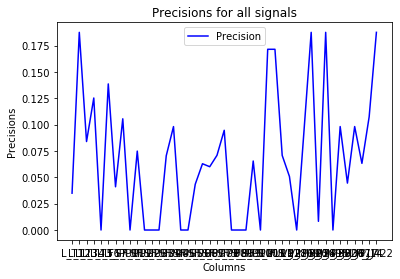

In [40]:
grams_freq = {}
def create_ngrams(n, data):
    gram = []
    ng = ngrams(data,n)
    for g in ngrams(data,n):
        gr = ''.join(g)
        if gr not in grams_freq.keys():
            grams_freq[gr] = 0
        gram.append(gr)        
    return ng,gram


def ret_window(window):
    ng_dict = {}
    for n in window:
        if n in ng_dict.keys():
            ng_dict[n]+=1
        else:
            ng_dict[n] = 1
    
    return ng_dict


def n_gram_calculation(df, column, n_segments, alphabet_size_avg, ngram_size, window_size, overlap):
    df_train_1 = df[column]
    scalar_series = TimeSeriesScalerMeanVariance(mu=0., std=np.std(df_train_1)).fit_transform(df_train_1)

    sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=alphabet_size_avg)
    sax_d = sax.fit_transform(scalar_series)
    df_discrete = sax.inverse_transform(sax_d)[0]

    unique_values = []
    for item in df_discrete:
        if item not in unique_values:
            unique_values.append(item[0])
            
    alphabet_mapping = 'abcdefghijklmnopqrstuvwxyz'
    the_dict = {x: alphabet_mapping[i] for i,x in enumerate(unique_values)}
    the_list = [the_dict[x[0]] for x in df_discrete]

    ng, n_gram = create_ngrams(ngram_size, the_list)
    ng_dict1 = {}
    for n in n_gram:
        if n in ng_dict1.keys():
            ng_dict1[n]+=1
        else:
            ng_dict1[n] = 1
    
    df_rs = pd.DataFrame(columns=list(ng_dict1.keys()))
    start_pos = 0
    end_pos = window_size
    window = 0
    ngd_list = []
    windows = {}
    while start_pos < end_pos:
        windows[start_pos] = n_gram[start_pos:end_pos]
        ngd = ret_window(n_gram[start_pos:end_pos])
        start_pos= start_pos + window_size - overlap
        end_pos = start_pos + window_size
        ngd_list.append(ngd)
        if end_pos == len(n_gram):
            break
        if end_pos > len(n_gram):
            end_pos = len(n_gram)
        df_rs = df_rs.append(ngd, ignore_index=True)
        
    if column == "L_T1":
        display(df_rs.head()) # displaying table only for L_T1
    return ngd_list, windows

window_size = 1000
overlap = 100
nsegments_train = 10
nsegments_test = 10
alphabet_size = 10
ngram_size = 4
precisions = []
columns = [column for column in clean_training_data.columns]
for column in clean_training_data.columns:
    ngd_train, windows_train = n_gram_calculation(clean_training_data, column, nsegments_train, alphabet_size, ngram_size, window_size, overlap)
    ngd_test, windows_test = n_gram_calculation(training_evaluation_data, column, nsegments_test, alphabet_size, ngram_size, window_size, overlap)

    attack_results = []
    pos = 0
    for i in range(len(ngd_test)):
        training = ngd_train[i]
        testing = ngd_test[i]
        anomalies = [item for item in testing.keys() if item not in training.keys()]
        w = windows_test[pos]
        for anomaly in w:
            if anomaly in anomalies:
                if pos not in attack_results:
                    attack_results.append(pos)
            pos = pos+1
        pos = pos - overlap

    
    false_positives = list(set(attack_results) - set(attack_indices))
    true_positives = [item for item in attack_results if item in attack_indices]
    precision = len(true_positives) / (len(true_positives)+len(false_positives))
    precisions.append(precision)
    print("for column: %s => fp: %d , tp: %d, precision: %.5f" % (column, len(false_positives), len(true_positives), precision))
    
plt.title("Precisions for all signals")
plt.plot(columns, precisions, color='b', label='Precision')
plt.xlabel('Columns')
plt.ylabel('Precisions')
plt.legend()
plt.show()

4-grams was chosen to convert the data into N-grams. Once all the data points were converted to n-grams, where 4 data points are taken as one window, we then split the entire data set into windows on the basis of time. For example, with window size 1000, the first 1000 n-grams for that signal is taken. Then the second window is taken in the range 900-1900, then the 3rd window segement is 1800-2800, and so on. In this way, it will be possible to localize an anomaly in a span of short window. That is if we compare the 2nd window of the training data set with the 2nd window of the evaluation data set, then if there are ngrams that do not exist in the evaluation data set for this window, it can categorized as an anomaly for this window, and we can then say that 2nd division of time consists of an anomaly. This is further inspected by extracting the data points. But because the data is discretized and converted to ngrams, the exact data points where the anomaly can be found is determined with less probability. This might be the reason why, as seen in the above plots and the precision data, we get less precision using this method. The tables above show the sliding windows over the time period for the selected ngrams for the signal L_T1.

As stated above, we consider it an anomaly if an ngrams is present in the testing set but not in the training set. Therefore, the anomalies detected here are based on signatures. If the signature of the testing set varies from that of the training set, an alarm is raised. 

We can also see that the precision is the highest for L_T2, P_J300, P_J289, and P_J422. We also see a significant number of True positives for F_PU11 and S_PU11. These signals can be used for detecting anomalies in a relatively better manner. Also signals F_PU2, F_PU10, and F_V2 give all the true positives, 219, but with a high numbrr of false positives which can concur a lot of cost if the process of validation is expensive.


### 6.Comparision

From the given instructions we try to evaluate the performance of the above implemented four tasks (LOF, PCA, ARMA and N-gram model) on the basis of true positives and false positives. The comparison of the given four methods is not easy because all of these methods have different implementation to find anomalies. Below are the precisions for all the four methods (precision = tp / (tp + fp)), based on which we make our comparisons.

LOF : 0.287 (with k = 17)

PCA : 21/25 = 0.84

ARMA: 4/8 = 0.50

N-Gram: 0.18750 (with multiple signals as stated in its respective answer)

LOF uses the concept of outliers to find anomalies. If a datapoint lies far away from its cluster, then it is detected as an anomaly. As there are always abnormalities in the signals, especially in an ICS system, detecting anomalies through outliers is bound to give significant number of false positives. However, we also note here that in spite of giving false positives, there are also significant number of true positives given by this method.  

In PCA point wise detection of true positives and false positives, made the task a bit easier. TP is nothing but a point detected in the anomolous region based of residuals and thresholds (potential_attacks). The choice of 15 most important components and computed thresholds of the anomalies led to the detection of 21 true positives and 4 false positives from the computed list of 25 potential attacks. 

ARMA is not a point-based implementaion and works on signals. Thus, we tried evaluating multiple signals like L_T6, L_T1 and F_PU1 and found out that L_T1 analysis and results seemed to be the best hence, we chose that. However, our approach creates a biasness in the system because if an attack is made on one of the signal, the others might be unaware of the same, due to the single signal processing that we did in our model.

N-Grams depends on signature based detection using a series of ngrams. However, this signature is computed over different periods in time, and therefore, proper alignment of the time-series data needs to be done. This alignment proves as a hinderence for attaining efficiency in this case, and results in low precision. In some case, all the anomalies are detected but giving a lot of false positives at the same time. 

To conclude based on the precision scores (which is an important metric in terms of evaluating a model), we could clearly spot that PCA outperforms every other model and it might be because:
* it enables the user to choose the most significant signals thus reducing the features of the given large data 
* because it considers point wise implementation which is easier to analyse